# Taiwan COVID-19 Contact Tracing Dataset (Preprocessing + Network Modeling)

**Study topic:** *How advances in contact tracing technology used during COVID-19 can help predict future epidemics and pandemics.*

**What this notebook does**
- Loads a contact-tracing-style dataset (individual case records + contact edges).
- Preprocesses dates / missing values, then engineers **state-transition durations** (e.g., symptom -> confirmed).
- Reconstructs a **contact network** and extracts **clusters** (connected components).
- Estimates **secondary attack rate (SAR)** by interaction type as a simple transmission-risk proxy.

> **Note:** Some cells assume a Google Colab environment (Google Drive mounting). The notebook will automatically try to load the `.xlsx` from the same folder.


**Prepared by:**
- Email: wiener baalls

### Libraries used
- **pandas**: reading/cleaning tabular data (Excel sheets -> DataFrames)
- **matplotlib**: plotting
- **lifelines**: Kaplan–Meier survival curves (used here to visualize time-to-transition distributions)
- **networkx**: contact network reconstruction and cluster analysis

# 0. Import packages

In [30]:
# Install external libraries
%pip install lifelines

In [31]:
# Import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from lifelines import KaplanMeierFitter

# Shorten KaplanMeierFitter() function
kmf = KaplanMeierFitter()

In [32]:
# Import Google Drive directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import and preview the DataFrame

## The dataset (contact tracing perspective)

This `.xlsx` file contains multiple sheets:

- **Individual Data**: one row per case/person (demographics + key dates like onset, confirmation, recovery, ICU, death).
- **Edge List**: contact edges between people, with an **interaction type** and whether the edge is **directed** (known transmission) or **undirected** (contact).

Why this matters for our topic:
- Contact tracing technology produces **who-met-whom** (edges) and **when key events happened** (dates).
- These let us estimate *how fast* infections progress (state transitions) and *where* spread concentrates (clusters).


In [33]:
# Import DataFrame
file_path = '/content/drive/MyDrive/Colab Notebooks/colab-files/figshare_taiwan_covid.xlsx'
df_ind = pd.read_excel(file_path, sheet_name='Individual Data')

In [34]:
# View a preview of the DataFrame
df_ind.tail(5)

,id,abroad/local,infection_source,visited_countries/cities,date_of_departure_1,date_of_arrival_1,visited_country/city_1,date_of_departure_2,date_of_arrival_2,visited_country/city_2,...,date_of_contact_with_infected_case,source_infected_cases_all,source_infected_case,earliest_infection_date,negative_test_date_1,negative_test_date_2,negative_test_date_3,negative_test_date_4,detail,source
573,5,Abroad,China,Wuhan,NaN,NaN,Wuhan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,"business;\nOn the 26th, there were 119 newly n...",https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
574,4,Abroad,China,"Wuhan, Europe",2020-01-13,NaN,Wuhan,2020-01-15,2020-01-16,Europe,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,travelling;\n新增1例境外移入嚴重特殊傳染性肺炎病例，為北部50多歲女性，1月1...,https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
575,3,Abroad,China,Wuhan,NaN,NaN,Wuhan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,"business; \nAs of 4:00 pm on January 24, there...",https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
576,2,Abroad,China,Travel to Taiwan,NaN,NaN,Travel to Taiwan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,travelling\n50多歲男性國人(案2)，皆為1月21日入境；案1為1月23日因發燒...,https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
577,1,Abroad,China,Wuhan,NaN,NaN,Wuhan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,business\n50多歲中國籍女性(案1)，皆為1月21日入境；案2於1月20日出現感冒...,https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...


In [35]:
# View variables
df_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  578 non-null    int64         
 1   abroad/local                        577 non-null    object        
 2   infection_source                    474 non-null    object        
 3   visited_countries/cities            472 non-null    object        
 4   date_of_departure_1                 440 non-null    object        
 5   date_of_arrival_1                   39 non-null     object        
 6   visited_country/city_1              471 non-null    object        
 7   date_of_departure_2                 77 non-null     object        
 8   date_of_arrival_2                   9 non-null      object        
 9   visited_country/city_2              30 non-null     object        
 10  date_of_departure_3       

# 2. Preprocess Data

## Preprocessing techniques: Converting date objects (data consistency)


In [36]:
# Convert all date columns to datetime objects
date_cols = ['date_of_departure_1', 'date_of_arrival_1', 'date_of_departure_2', 'date_of_arrival_2', 'date_of_departure_3',
             'date_of_arrival_3', 'date_of_departure_4', 'date_of_arrival_4', 'date_of_transit', 'date_of_arrival_to_taiwan',
             'onset_of_symptom', 'report_to_cdc', 'confirmed_date', 'icu', 'recovery', 'death_date',
             'date_of_contact_with_infected_case', 'earliest_infection_date', 'negative_test_date_1', 'negative_test_date_2',
             'negative_test_date_3', 'negative_test_date_4']
for col in date_cols:
    df_ind[col] = pd.to_datetime(df_ind[col], errors='coerce', utc='True')

# 3. Definte State Mapping Logic

Convert the case timeline into **durations** (in days) between important COVID-19 states:

- **IA -> IS**: infection (proxy) -> symptom onset  
- **IS -> C**: symptom onset -> confirmed  
- **C -> ICU / R / D**: confirmed -> ICU / recovery / death  

These engineered durations can be used as inputs for:
- forecasting *how quickly* cases progress,
- comparing subgroups (age/gender),
- and supporting simulation/early-warning models for future outbreaks.

In [37]:
# Create Infection Onset to Symptom variable
df_ind['duration_IA_to_IS'] = (df_ind['onset_of_symptom'] - df_ind['earliest_infection_date']).dt.days
# Create Symptom Onset to Confirmation variable
df_ind['duration_IS_to_C'] = (df_ind['confirmed_date'] - df_ind['onset_of_symptom']).dt.days
# Create Confirmed Onset to ICU variable
df_ind['duration_C_to_IC'] = (df_ind['icu'] - df_ind['confirmed_date']).dt.days
# Create Confirmed Onset to Recovery variable
df_ind['duration_C_to_R'] = (df_ind['recovery'] - df_ind['confirmed_date']).dt.days
# Create Confirmed Onset to Death variable
df_ind['duration_C_to_D'] = (df_ind['death_date'] - df_ind['confirmed_date']).dt.days

df_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   id                                  578 non-null    int64              
 1   abroad/local                        577 non-null    object             
 2   infection_source                    474 non-null    object             
 3   visited_countries/cities            472 non-null    object             
 4   date_of_departure_1                 74 non-null     datetime64[ns, UTC]
 5   date_of_arrival_1                   39 non-null     datetime64[ns, UTC]
 6   visited_country/city_1              471 non-null    object             
 7   date_of_departure_2                 77 non-null     datetime64[ns, UTC]
 8   date_of_arrival_2                   9 non-null      datetime64[ns, UTC]
 9   visited_country/city_2              30 non-

In [38]:
# Create boolean variable columns with the condition if the corresponding transitions occurred
df_ind['event_IA_to_IS'] = df_ind['onset_of_symptom'].notnull().astype(int)
df_ind['event_IS_to_C'] = df_ind['confirmed_date'].notnull().astype(int)
df_ind['event_C_to_IC'] = df_ind['icu'].notnull().astype(int)
df_ind['event_C_to_R'] = df_ind['recovery'].notnull().astype(int)
df_ind['event_C_to_D'] = df_ind['death_date'].notnull().astype(int)

# Verify
print(df_ind['event_IA_to_IS'].value_counts())
print(df_ind['event_IS_to_C'].value_counts())
print(df_ind['event_C_to_IC'].value_counts())
print(df_ind['event_C_to_R'].value_counts())
print(df_ind['event_C_to_D'].value_counts())

event_IA_to_IS
1    442
0    136
Name: count, dtype: int64
event_IS_to_C
1    578
Name: count, dtype: int64
event_C_to_IC
0    520
1     58
Name: count, dtype: int64
event_C_to_R
0    499
1     79
Name: count, dtype: int64
event_C_to_D
0    571
1      7
Name: count, dtype: int64


Another preprocessing technique is applied here by filtering out missing observations

In [ ]:
# Extract filtered observations into individual DataFrames
df_clean_IA_to_IS = df_ind.dropna(subset='duration_IA_to_IS')
df_clean_IS_to_C = df_ind.dropna(subset='duration_IS_to_C')
df_clean_C_to_IC = df_ind.dropna(subset='duration_C_to_IC')
df_clean_C_to_R = df_ind.dropna(subset='duration_C_to_R')
df_clean_C_to_D = df_ind.dropna(subset='duration_C_to_D')

# How many observations remain per transition?
print("IA->IS:", len(df_clean_IA_to_IS))
print("IS->C :", len(df_clean_IS_to_C))
print("C->ICU:", len(df_clean_C_to_IC))
print("C->R  :", len(df_clean_C_to_R))
print("C->D  :", len(df_clean_C_to_D))

IA->IS: 28
IS->C : 442
C->ICU: 58
C->R  : 79
C->D  : 7


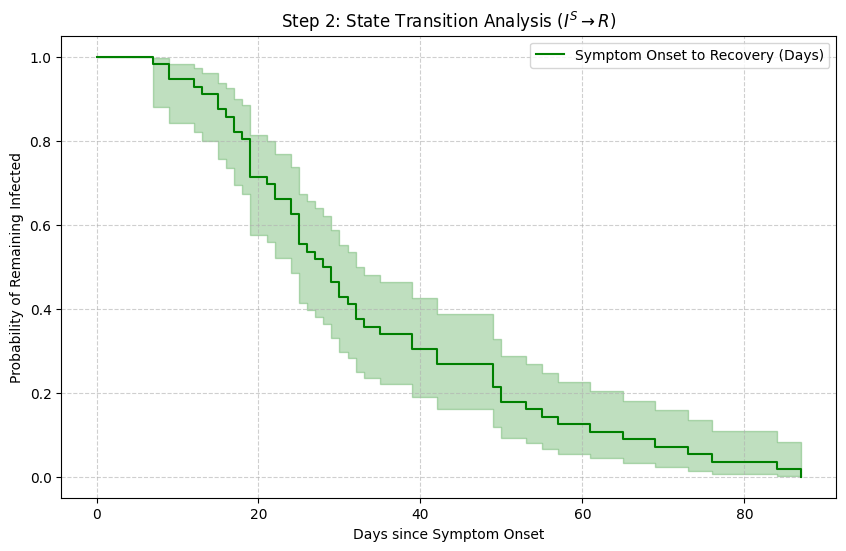

--- FINAL RESULTS ---
Median time from Symptoms to Recovery: 28.0 days


In [ ]:
# Combine Onset-to-Confirmation and Confirmation-to-Recovery
# This gives us the full Is -> R transition.
df_ind['total_recovery_time'] = df_ind['duration_IS_to_C'] + df_ind['duration_C_to_R']

# Filter out the negatives or NaNs
df_survival = df_ind[df_ind['total_recovery_time'] > 0].copy()

# Fit the Kaplan-Meier Curve
kmf.fit(df_survival['total_recovery_time'],
        event_observed=df_survival['event_C_to_R'], # Using the 'Recovery' event marker
        label='Symptom Onset to Recovery (Days)')

# Plot the result
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(color='green')
plt.title('Step 2: State Transition Analysis ($I^S \\rightarrow R$)')
plt.xlabel('Days since Symptom Onset')
plt.ylabel('Probability of Remaining Infected')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Output
median_days = kmf.median_survival_time_
print(f"--- FINAL RESULTS ---")
print(f"Median time from Symptoms to Recovery: {median_days} days")

## Visualization: Kaplan–Meier survival curves for transition times

Kaplan–Meier curves show the probability that a transition has **not yet happened** after *t* days.
In our context, it helps visualize typical delays (median time) for transitions like symptom -> confirmation.

> Fit on rows with available durations (completed transitions), so this is mainly used as an exploratory visualization.


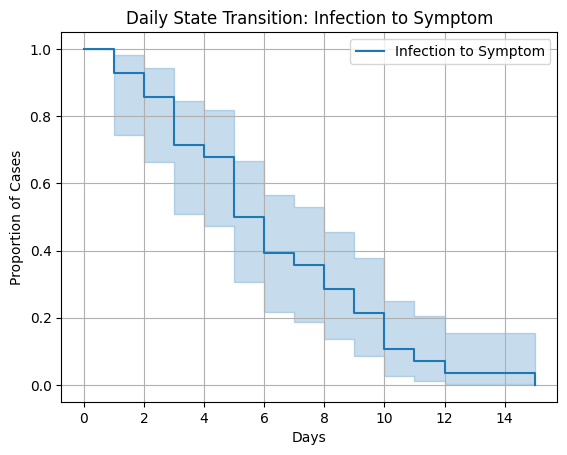

In [41]:
# Use kmf to estimate Infection to Symptom survival function
# Recreate df_clean_IA_to_IS to ensure 'event_IA_to_IS' column is present
kmf.fit(
    durations = df_clean_IA_to_IS['duration_IA_to_IS'],
    event_observed = df_clean_IA_to_IS['event_IA_to_IS'],
    label = 'Infection to Symptom'
)

kmf.plot_survival_function()
plt.title('Daily State Transition: Infection to Symptom')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

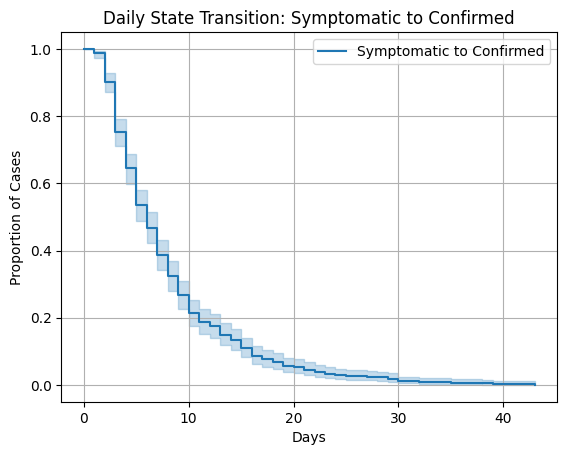

In [42]:
# Use kmf to estimate Symptomatic to Confirmed survival function
kmf.fit(
    durations = df_clean_IS_to_C['duration_IS_to_C'],
    event_observed = df_clean_IS_to_C['event_IS_to_C'],
    label = 'Symptomatic to Confirmed'
)

kmf.plot_survival_function()
plt.title('Daily State Transition: Symptomatic to Confirmed')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

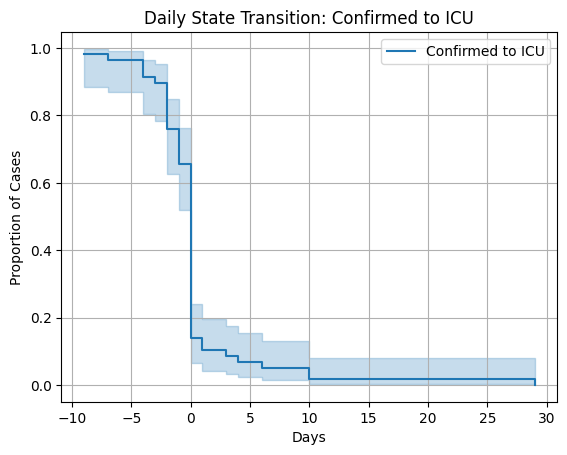

In [43]:
# Use kmf to estimate Confirmed to ICU survival function
kmf.fit(
    durations = df_clean_C_to_IC['duration_C_to_IC'],
    event_observed = df_clean_C_to_IC['event_C_to_IC'],
    label = 'Confirmed to ICU'
)

kmf.plot_survival_function()
plt.title('Daily State Transition: Confirmed to ICU')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

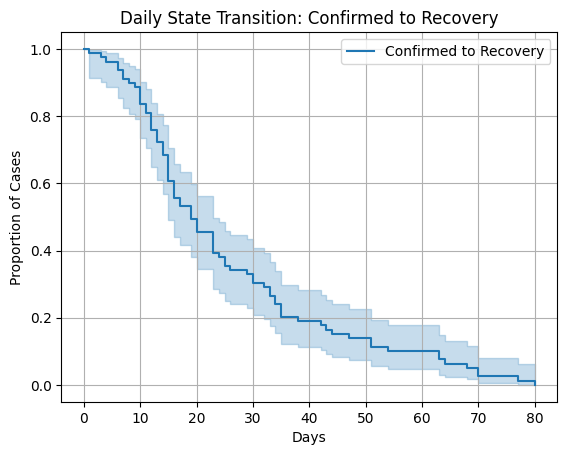

In [44]:
# Use kmf to estimate Confirmed to Recovery survival function
kmf.fit(
    durations = df_clean_C_to_R['duration_C_to_R'],
    event_observed = df_clean_C_to_R['event_C_to_R'],
    label = 'Confirmed to Recovery'
)

kmf.plot_survival_function()
plt.title('Daily State Transition: Confirmed to Recovery')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

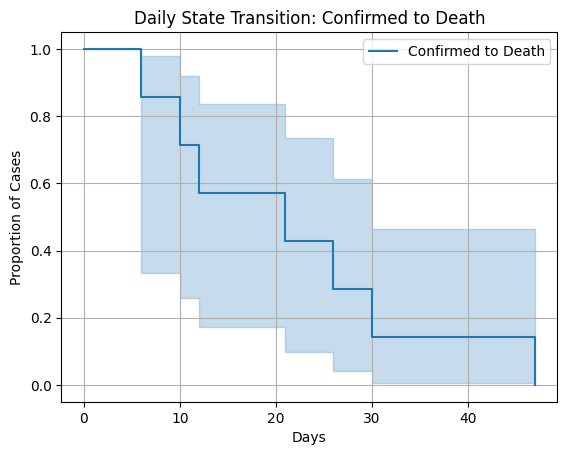

In [45]:
# Use kmf to estimate Confirmed to Death survival function
kmf.fit(
    durations = df_clean_C_to_D['duration_C_to_D'],
    event_observed = df_clean_C_to_D['event_C_to_D'],
    label = 'Confirmed to Death'
)

kmf.plot_survival_function()
plt.title('Daily State Transition: Confirmed to Death')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

# 3. Reconstruct the Contact Network

In contact tracing, each person is a **node**, and each recorded contact is an **edge**.

Build a mixed network:
- **Undirected edges** (`directed=False`): known contact, but not sure who infected whom.
- **Directed edges** (`directed=True`): a likely transmission direction (source -> target).

From this network:
- find **clusters** (connected components),
- estimate how concentrated spread is (e.g., whether a small number of clusters contain most people),
- and support early-warning analytics for future outbreaks.


In [46]:
# Network analysis library
import networkx as nx

## Step 4.1: Load the Edge List and initialize the graph

Load the contact edges and normalize IDs (`source_norm`, `target_norm`) using the same rules as `id_norm`.
Then create a **MultiDiGraph** to store:
- multiple edges between the same pair (if they had repeated contacts),
- and both directed + undirected relationships.


In [47]:
# Load edge list (contact edges)
df_edg = pd.read_excel(file_path, sheet_name='Edge List')

# Initialize a mixed graph
G = nx.MultiDiGraph()

print("Edges loaded:", len(df_edg))

Edges loaded: 46010


## Step 4.2: Add nodes + attributes

Each row in **Individual Data** becomes a node.
Attach a few attributes (age, gender, key dates) that can be used later for:
- stratified analysis (e.g., cluster size by age group),
- time-based features (e.g., confirmation date),
- and richer outbreak modeling.


In [48]:
# Add nodes using the original 'id' column from df_ind
# Converting to string to ensure consistent key types in networkx

for _, row in df_ind.iterrows():
    node_id = str(row['id'])

    attributes = {
        'age': row.get('age'),
        'gender': row.get('gender'),
        'confirmed_date': row.get('confirmed_date'),
        'asymptomatic_date': row.get('earliest_infection_date'),  # proxy for infection start
    }

    G.add_node(node_id, **attributes)

print(f"Graph initialized with {G.number_of_nodes()} nodes (from Individual Data)")

Graph initialized with 578 nodes (from Individual Data)


## Step 4.3: Add edges (contacts + transmission paths)

- If `directed=False`, treat it as a **contact** with no confirmed direction.
- If `directed=True`, treat it as a **likely transmission direction** (source -> target).

This separation is useful because future tracing technologies often provide:
- lots of contact edges (Bluetooth proximity, QR check-ins),
- but fewer high-confidence transmission directions (epidemiological investigation).


In [49]:
# Reconstruct edges using original IDs, converting to string
for _, row in df_edg.iterrows():
    # Convert source and target IDs to string directly
    source = str(row['source'])
    target = str(row['target'])

    interaction_type = int(row['interaction'])
    is_directed = bool(row['directed'])

    edge_attrs = {
        'interaction': interaction_type,
        'directed_path': is_directed
    }

    if is_directed:
        # Directed edge = likely transmission direction (source -> target)
        G.add_edge(source, target, color='red', **edge_attrs)
    else:
        # Undirected contact: represent by adding both directions
        G.add_edge(source, target, color='grey', **edge_attrs)
        G.add_edge(target, source, color='grey', **edge_attrs)

print(f"Graph reconstructed with {G.number_of_edges()} edges")

Graph reconstructed with 91983 edges


## Step 4.4: Cluster analysis (connected components)

A **cluster** here means a connected component in the undirected version of the contact network.
Clusters are important for epidemic prediction because they hint at:
- where outbreak “hotspots” form,
- how spread concentrates into a few groups,
- and which clusters might be prioritized for intervention.


In [ ]:
# Convert to undirected to find connected components
G_undirected = G.to_undirected()

# Get all clusters
clusters = list(nx.connected_components(G_undirected))

# Calculate stats
num_clusters = len(clusters)
cluster_sizes = [len(c) for c in clusters]
max_cluster = max(cluster_sizes)

print(f"Total Clusters Identified: {num_clusters}")
print(f"Largest Cluster Size: {max_cluster}")

Total Clusters Identified: 152
Largest Cluster Size: 1898


# 4.5 Secondary Attack Rate (SAR) proxy by interaction type


This is not a perfect epidemiological SAR (it depends on how the dataset defines edges), but it is a useful
*contact-tracing-driven signal* for which interaction contexts were higher risk.

In [ ]:
# Dictionary mapping interaction codes to names
interaction_map = {
    0: 'Couple', 1: 'Parent/Child', 2: 'Grandparent/Grandchild', 3: 'Brother/Sister',
    4: 'Family', 5: 'Friend', 6: 'Live together', 7: 'The same flight',
    8: 'Flight nearby seat', 9: 'Travel together', 10: 'School', 11: 'Car',
    12: 'Hotel', 13: 'Quarantine hotel', 14: 'Coworker', 15: 'Hospital',
    16: 'Panshi Ship', 17: 'Coral Princess', 18: 'Other', 19: 'Unclassified'
}

# Count Total Contacts per Interaction Type
total_counts = df_edg['interaction'].value_counts().sort_index()

# Count Infection Paths (Directed Edges) per Interaction Type
# edges where transmission actually occurred
infection_counts = df_edg[df_edg['directed'] == True]['interaction'].value_counts().sort_index()

# Combine into a DataFrame for SAR Analysis
sar_df = pd.DataFrame({
    'Interaction': [interaction_map.get(i, f'Type {i}') for i in total_counts.index],
    'Total_Contacts': total_counts.values,
    # Use 'get' to handle cases where an interaction type might have 0 infections
    'Infection_Events': [infection_counts.get(i, 0) for i in total_counts.index]
})

# Calculate Risk
sar_df['Transmission_Risk_Pct'] = (sar_df['Infection_Events'] / sar_df['Total_Contacts']) * 100

print(sar_df.sort_values('Transmission_Risk_Pct', ascending=False))

               Interaction  Total_Contacts  Infection_Events  \
2   Grandparent/Grandchild               2                 1   
6            Live together              40                 6   
1             Parent/Child               7                 1   
0                   Couple              32                 4   
5                   Friend               8                 1   
15                Hospital              31                 3   
4                   Family              58                 4   
11                     Car             562                 1   
7          The same flight            5406                 7   
10                  School            1203                 1   
18                   Other           16446                 8   
3           Brother/Sister               2                 0   
8       Flight nearby seat             868                 0   
9          Travel together             805                 0   
13        Quarantine hotel              

## Visualization: Contact vs transmission counts by interaction type

This bar plot compares:
- **Total contacts** (how often an interaction occurred), and
- **Infection events** (directed edges) as a proxy for transmission.

log scale is used because some interaction types are much more common than others.


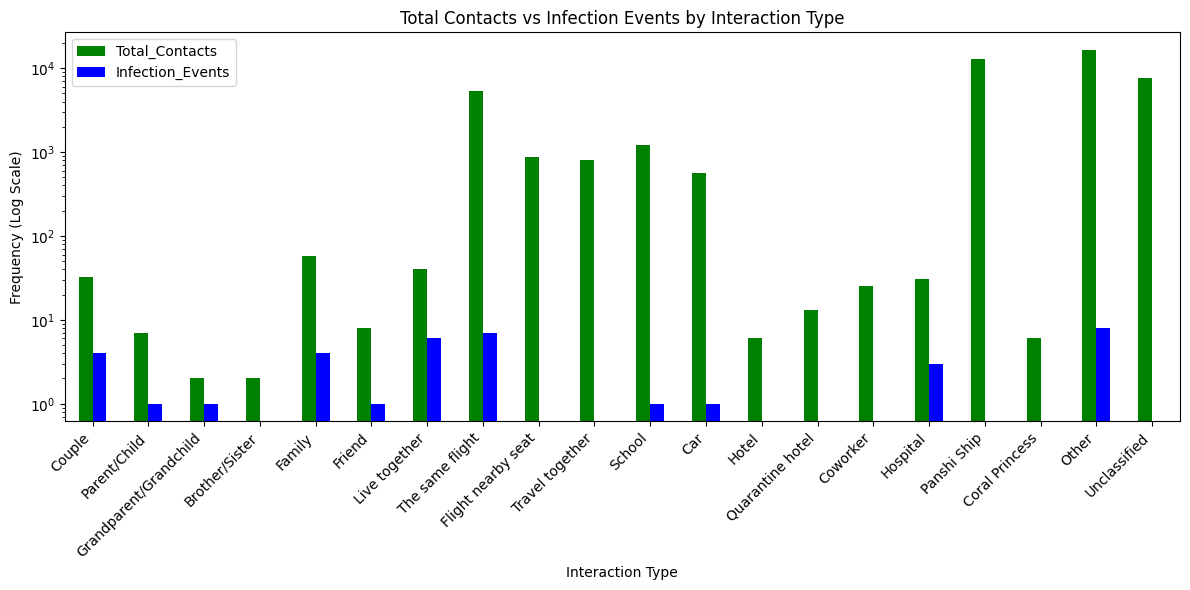

In [ ]:
# Plot graph
ax = sar_df.plot(x='Interaction', y=['Total_Contacts', 'Infection_Events'], kind='bar',
                 figsize=(12, 6), color=['green', 'blue'], logy=True)

plt.title('Total Contacts vs Infection Events by Interaction Type')
plt.ylabel('Frequency (Log Scale)')
plt.xlabel('Interaction Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Transitions from Infection to Symptoms to Confirmation
df_ind['duration_IA_to_IS'] = (df_ind['onset_of_symptom'] - df_ind['earliest_infection_date']).dt.days
df_ind['duration_IS_to_C'] = (df_ind['confirmed_date'] - df_ind['onset_of_symptom']).dt.days

# Outcomes (Recovery, ICU, or Death)
df_ind['duration_C_to_IC'] = (df_ind['icu'] - df_ind['confirmed_date']).dt.days
df_ind['duration_C_to_R'] = (df_ind['recovery'] - df_ind['confirmed_date']).dt.days
df_ind['duration_C_to_D'] = (df_ind['death_date'] - df_ind['confirmed_date']).dt.days

# Making Variable for Symptom to Recovery
# Is -> C -> R
df_ind['duration_IS_to_R'] = df_ind['duration_IS_to_C'] + df_ind['duration_C_to_R']

# Cleaning Data Entry Errors (negative days)
df_ind = df_ind[(df_ind['duration_IS_to_C'] >= 0) | (df_ind['duration_IS_to_C'].isna())]
df_ind = df_ind[(df_ind['duration_C_to_R'] >= 0) | (df_ind['duration_C_to_R'].isna())]

✅ All variables (ICU, Recovery, Death) are now locked and loaded.


In [ ]:
# CLUSTER IMPACT ANALYSIS
import numpy as np

# Get the sizes of all identified clusters
cluster_sizes = [len(c) for c in clusters]

# Sort them to find the Most Significant Cluster
sorted_clusters = sorted(cluster_sizes, reverse=True)

# Check top 10% of clusters if they cause the most infections
top_10_percent_count = max(1, int(len(sorted_clusters) * 0.1))
top_10_impact = sum(sorted_clusters[:top_10_percent_count])
total_infections = sum(sorted_clusters)
impact_pct = (top_10_impact / total_infections) * 100

print(f"Total Clusters: {len(clusters)}")
print(f"Largest Cluster Size: {max(cluster_sizes)} people")
print(f"The top 10% of clusters account for {impact_pct:.2f}% of all cases.")

--- SUPERSPEADER RESULTS ---
Total Clusters: 152
Largest Cluster Size: 1898 people
The top 10% of clusters account for 72.83% of all cases.


In [ ]:
# Use the sar_df built earlier from the interaction_map
# Filter for types with more than 5 contacts to keep the math 'clean'
reliable_sar = sar_df[sar_df['Total_Contacts'] > 5].copy()

# Sort by the highest Transmission Risk Pct
reliable_sar = reliable_sar.sort_values('Transmission_Risk_Pct', ascending=False)

print(reliable_sar[['Interaction', 'Total_Contacts', 'Infection_Events', 'Transmission_Risk_Pct']])

# Summary
top_risk = reliable_sar.iloc[0]['Interaction']
risk_val = reliable_sar.iloc[0]['Transmission_Risk_Pct']
print(f"\nCONCLUSION: '{top_risk}' is the highest risk environment with a {risk_val:.2f}% transmission rate.")

--- SECONDARY ATTACK RATE (SAR) RANKING ---
           Interaction  Total_Contacts  Infection_Events  \
6        Live together              40                 6   
1         Parent/Child               7                 1   
0               Couple              32                 4   
5               Friend               8                 1   
15            Hospital              31                 3   
4               Family              58                 4   
11                 Car             562                 1   
7      The same flight            5406                 7   
10              School            1203                 1   
18               Other           16446                 8   
8   Flight nearby seat             868                 0   
9      Travel together             805                 0   
13    Quarantine hotel              13                 0   
12               Hotel               6                 0   
14            Coworker              25                 0

## Step 5: Data validation and correlation

This step *cross-checks* the dataset at two levels:

1) **Cross-verification (individual vs. population level)**  
   Aggregate the **individual-level confirmed cases** (by day and by category: *Abroad / Local / Navy / Unknown*) and compare them to the **population-level daily summary** totals.

2) **Predictive application (testing-adjusted estimation)**  
   Integrate the daily **number of tests performed** and use it to (crudely) adjust for changes in **case detection** over time, then examine how **testing intensity** relates to estimating the effective reproduction number ($R_E$).


In [56]:
# Load the remaining sheets
try:
    df_summary = pd.read_excel(file_path, sheet_name='Summary')
    df_specimen = pd.read_excel(file_path, sheet_name='Specimen')
except Exception as e:
    # Fallback if running locally
    df_summary = pd.read_excel('figshare_taiwan_covid.xlsx', sheet_name='Summary')
    df_specimen = pd.read_excel('figshare_taiwan_covid.xlsx', sheet_name='Specimen')

# Standardize announce_date to a daily timestamp (no time-of-day)
df_summary['announce_date'] = pd.to_datetime(df_summary['announce_date'], errors='coerce')
df_summary['date'] = df_summary['announce_date'].dt.normalize()

df_specimen['announce_date'] = pd.to_datetime(df_specimen['announce_date'], errors='coerce')
df_specimen['date'] = df_specimen['announce_date'].dt.normalize()

# Build a clean daily positive-case table from the Summary sheet
summary_cols = [
    'number_of_suspected_case_repoted_to_cdc',
    'number_of_abroad_positive_cases',
    'number_of_local_positive_cases',
    'number_of_positive_cases_from_panshi_ship',
    'number_of_unknown_positive_cases'
]
for c in summary_cols:
    if c in df_summary.columns:
        df_summary[c] = pd.to_numeric(df_summary[c], errors='coerce').fillna(0)

df_summary['positive_total'] = (
    df_summary.get('number_of_abroad_positive_cases', 0) +
    df_summary.get('number_of_local_positive_cases', 0) +
    df_summary.get('number_of_positive_cases_from_panshi_ship', 0) +
    df_summary.get('number_of_unknown_positive_cases', 0)
)

df_summary_daily = df_summary[['date'] + [c for c in summary_cols if c in df_summary.columns] + ['positive_total']].copy()

# Daily testing volume (Specimen sheet's total)
df_specimen['total'] = pd.to_numeric(df_specimen['total'], errors='coerce').fillna(0)
df_tests_daily = df_specimen[['date', 'total']].rename(columns={'total': 'tests_total'}).copy()

print("Summary daily rows:", len(df_summary_daily))
print("Specimen (tests) daily rows:", len(df_tests_daily))


Summary daily rows: 783
Specimen (tests) daily rows: 860


## Visualization: Step 5B (Cross-verification graphs)

### 1) Cross-Verification: *Summary vs Individual vs Onset-shift Prediction*
This line chart compares three ways of counting daily cases (smoothed with a **7‑day average** to reduce day-to-day noise):

- **Summary positives**: the official daily total in the *Summary* sheet.
- **Individual confirmed**: count of confirmations from the *Individual Data* sheet by date.
- **Onset‑shift predicted**: symptom onset dates and shifted forward by the *typical reporting delay* (median onset->confirmed).  
  This simulates: “If people are usually confirmed **X days** after symptoms start, what would the daily confirmations look like?”

**How to read it**
- When the lines move together, it suggests the individual-level dataset is consistent with the population-level reporting.
- If the individual line is lower or missing peaks, it often means the individual sheet is **incomplete** for those dates (or has missing dates).
- If the onset‑shift line matches well, it suggests the “typical delay” is fairly stable across time.

---

### 2) Cross-Verification by Category (Abroad / Local / Navy / Unknown)
This chart repeats the same idea but splits cases into categories. It helps validate whether the **travel/source labels** in the individual data match how the official summary reports them.

**How to read it**
- Close matching lines = category labels in the individual sheet are aligned with the summary definitions.
- Large gaps usually mean:
  - missing category labels in individual rows,
  - different category definitions, or
  - timing/reporting differences (cases are recorded on different dates across sheets).

---

### 3) Ratio: Daily Infected / Daily Suspected
This graph shows:

- **Daily infected** = confirmed positives (from the Summary sheet)
- **Daily suspected** = suspected cases reported to CDC (from the Summary sheet)

So the ratio is a simple “**how many suspected cases turn out to be positive**” signal.

**How to read it**
- A **higher ratio** can mean spread is rising *or* that the system is testing more narrowly (only high‑risk suspected cases).
- A **lower ratio** can mean broader testing, better early detection, or fewer positives among suspected cases.
- For prediction, this ratio is useful because it links **demand on tracing/testing** (suspected cases) to **detected infections**.


Estimated median reporting delay (onset -> confirmed): 6 days
Correlation (Summary total vs Individual confirmed): -0.058
Correlation (Summary total vs Onset-shift predicted): -0.0455
Mean absolute error (total): 27416.644
Mean % error (total, where summary>0): 99.014 %


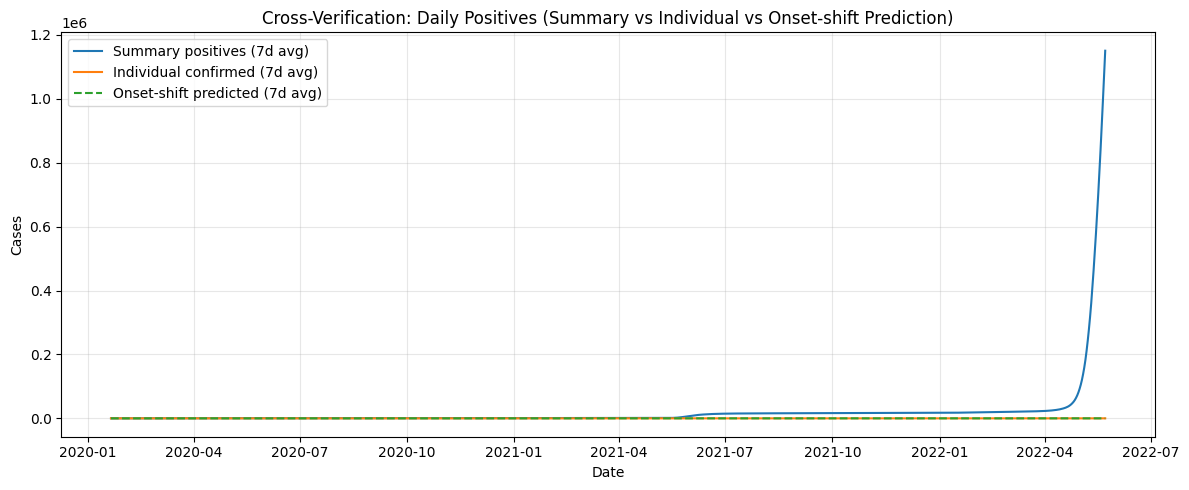

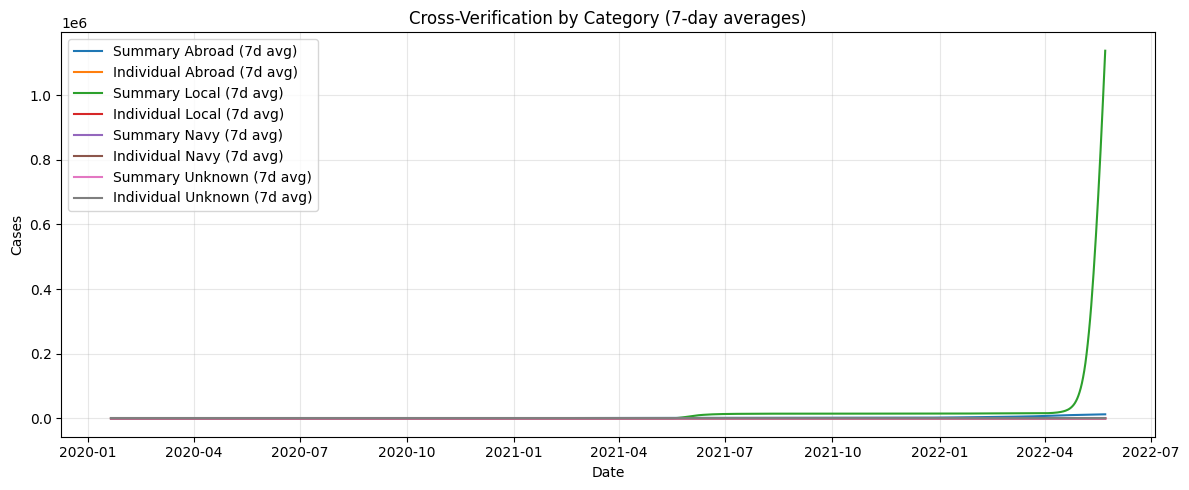

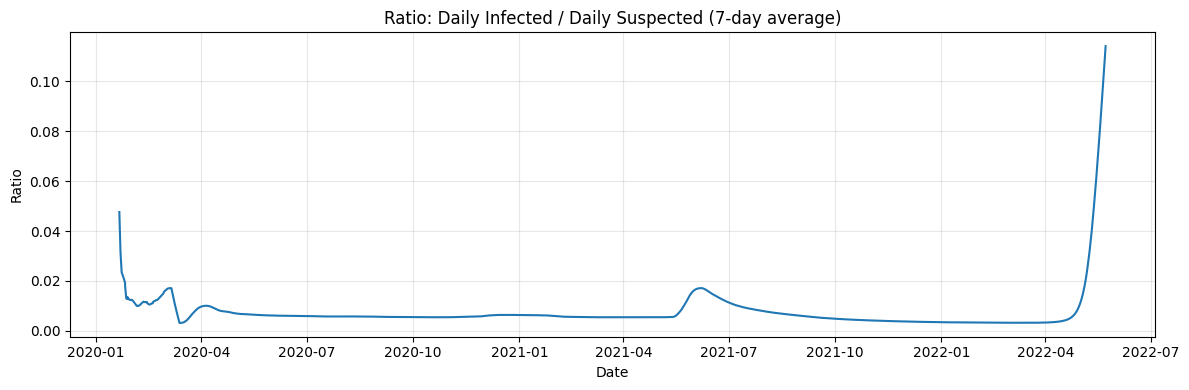

In [ ]:
# normalize date columns from df_ind (handles tz-aware or naive)
def to_daily(ts):
    ts = pd.to_datetime(ts, errors='coerce')
    # If tz-aware, drop timezone safely
    try:
        ts = ts.dt.tz_localize(None)
    except Exception:
        pass
    return ts.dt.normalize()

# Individual-level daily confirmed counts (total + by category)
df_ind['confirmed_day'] = to_daily(df_ind['confirmed_date'])
df_ind['onset_day'] = to_daily(df_ind['onset_of_symptom'])

ind_total = df_ind.dropna(subset=['confirmed_day']).groupby('confirmed_day').size().rename('ind_confirmed_total')

ind_abroad = df_ind[(df_ind['abroad/local'] == 'Abroad') & df_ind['confirmed_day'].notna()].groupby('confirmed_day').size().rename('ind_abroad')
ind_local  = df_ind[(df_ind['abroad/local'] == 'Local') & df_ind['confirmed_day'].notna()].groupby('confirmed_day').size().rename('ind_local')
ind_navy   = df_ind[(df_ind['abroad/local'] == 'Navy')  & df_ind['confirmed_day'].notna()].groupby('confirmed_day').size().rename('ind_navy')
ind_unknown = df_ind[(df_ind['abroad/local'].isna()) & df_ind['confirmed_day'].notna()].groupby('confirmed_day').size().rename('ind_unknown')

df_ind_daily = pd.concat([ind_total, ind_abroad, ind_local, ind_navy, ind_unknown], axis=1).fillna(0).reset_index().rename(columns={'confirmed_day':'date'})

# use symptom onset and median delay to predict confirmation dates
delay_days = (df_ind['confirmed_day'] - df_ind['onset_day']).dt.days
median_delay_raw = np.nanmedian(delay_days)
median_delay = 0 if np.isnan(median_delay_raw) else int(np.round(median_delay_raw))
print("Estimated median reporting delay (onset -> confirmed):", median_delay, "days")

df_onset = df_ind.dropna(subset=['onset_day']).copy()
df_onset['predicted_confirmed_day'] = df_onset['onset_day'] + pd.to_timedelta(median_delay, unit='D')
predicted_daily = df_onset.groupby('predicted_confirmed_day').size().rename('pred_confirmed_total').reset_index().rename(columns={'predicted_confirmed_day':'date'})

# Merge individual-derived and summary-derived
df_validate = df_summary_daily.merge(df_ind_daily, on='date', how='left').merge(predicted_daily, on='date', how='left')
df_validate[['ind_confirmed_total','pred_confirmed_total','ind_abroad','ind_local','ind_navy','ind_unknown']] = (
    df_validate[['ind_confirmed_total','pred_confirmed_total','ind_abroad','ind_local','ind_navy','ind_unknown']].fillna(0)
)

# Simple errors and correlations
df_validate['abs_err_total'] = (df_validate['positive_total'] - df_validate['ind_confirmed_total']).abs()
df_validate['pct_err_total'] = np.where(df_validate['positive_total'] > 0,
                                        df_validate['abs_err_total'] / df_validate['positive_total'] * 100,
                                        np.nan)

corr_ind_vs_summary = df_validate[['positive_total','ind_confirmed_total']].corr().iloc[0,1]
corr_pred_vs_summary = df_validate[['positive_total','pred_confirmed_total']].corr().iloc[0,1]

print("Correlation (Summary total vs Individual confirmed):", round(corr_ind_vs_summary, 4))
print("Correlation (Summary total vs Onset-shift predicted):", round(corr_pred_vs_summary, 4))
print("Mean absolute error (total):", round(df_validate['abs_err_total'].mean(), 3))
print("Mean % error (total, where summary>0):", round(np.nanmean(df_validate['pct_err_total']), 3), "%")

# Daily infected to daily suspected
if 'number_of_suspected_case_repoted_to_cdc' in df_validate.columns:
    df_validate['infected_to_suspected_ratio'] = np.where(
        df_validate['number_of_suspected_case_repoted_to_cdc'] > 0,
        df_validate['positive_total'] / df_validate['number_of_suspected_case_repoted_to_cdc'],
        np.nan
    )

plot_df = df_validate.sort_values('date').copy()
plot_df['summary_total_7d'] = plot_df['positive_total'].rolling(7, min_periods=1).mean()
plot_df['ind_total_7d'] = plot_df['ind_confirmed_total'].rolling(7, min_periods=1).mean()
plot_df['pred_total_7d'] = plot_df['pred_confirmed_total'].rolling(7, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(plot_df['date'], plot_df['summary_total_7d'], label='Summary positives (7d avg)')
plt.plot(plot_df['date'], plot_df['ind_total_7d'], label='Individual confirmed (7d avg)')
plt.plot(plot_df['date'], plot_df['pred_total_7d'], label='Onset-shift predicted (7d avg)', linestyle='--')
plt.title('Cross-Verification: Daily Positives (Summary vs Individual vs Onset-shift Prediction)')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Category-by-category check (abroad / local / navy / unknown)
plt.figure(figsize=(12, 5))
if 'number_of_abroad_positive_cases' in plot_df.columns:
    plt.plot(plot_df['date'], plot_df['number_of_abroad_positive_cases'].rolling(7, min_periods=1).mean(), label='Summary Abroad (7d avg)')
plt.plot(plot_df['date'], plot_df['ind_abroad'].rolling(7, min_periods=1).mean(), label='Individual Abroad (7d avg)')

if 'number_of_local_positive_cases' in plot_df.columns:
    plt.plot(plot_df['date'], plot_df['number_of_local_positive_cases'].rolling(7, min_periods=1).mean(), label='Summary Local (7d avg)')
plt.plot(plot_df['date'], plot_df['ind_local'].rolling(7, min_periods=1).mean(), label='Individual Local (7d avg)')

if 'number_of_positive_cases_from_panshi_ship' in plot_df.columns:
    plt.plot(plot_df['date'], plot_df['number_of_positive_cases_from_panshi_ship'].rolling(7, min_periods=1).mean(), label='Summary Navy (7d avg)')
plt.plot(plot_df['date'], plot_df['ind_navy'].rolling(7, min_periods=1).mean(), label='Individual Navy (7d avg)')

if 'number_of_unknown_positive_cases' in plot_df.columns:
    plt.plot(plot_df['date'], plot_df['number_of_unknown_positive_cases'].rolling(7, min_periods=1).mean(), label='Summary Unknown (7d avg)')
plt.plot(plot_df['date'], plot_df['ind_unknown'].rolling(7, min_periods=1).mean(), label='Individual Unknown (7d avg)')

plt.title('Cross-Verification by Category (7-day averages)')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Infected-to-suspected ratio
if 'infected_to_suspected_ratio' in plot_df.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(plot_df['date'], plot_df['infected_to_suspected_ratio'].rolling(7, min_periods=1).mean())
    plt.title('Ratio: Daily Infected / Daily Suspected')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Visualization: Step 5C (Testing-adjusted detection + $R_E$ graphs)

### 4) Observed vs Testing‑Adjusted Daily Cases
This chart compares:
- **Observed positives**: confirmed cases as reported.
- **Testing‑adjusted cases**: a simple adjustment that accounts for days when fewer (or more) tests were performed.

**How to read it**
- If testing drops, observed cases may drop even if true infections didn’t. The adjusted line tries to show what cases *might* look like under “typical” testing levels.
- This supports the study because contact tracing technology depends on **detection**: cases can be traced.

---

### 5) Daily Testing Volume (7‑day average)
This line chart shows the **testing intensity** over time.

**How to read it**
- Peaks and dips often reflect policy changes, surges, or capacity limits.
- Testing volume is important context: low testing can hide outbreaks; high testing can reveal them earlier.

---

### 6) Effective Reproduction Number ($R_E$) over time
$R_E$ is a simple way to describe spread:
- **$R_E > 1$** means infections are growing (each infected person infects more than one person on average).
- **$R_E < 1$** means infections are shrinking.

plot two versions:
- **Raw $R_E$** from observed cases
- **Adjusted $R_E$** using testing‑adjusted cases

**How to read it**
- If the adjusted line is noticeably different from the raw line, it suggests testing intensity changes can affect how to interpret “how fast the outbreak is spreading.”
- In a real public‑health setting, this matters because decisions are often based on whether $R_E$ is above or below 1.

---

### 7) Testing intensity vs $\left|R_E^{adj} - R_E^{raw}\right|$ (scatter plot)
Each dot is one day:
- **x‑axis**: number of tests performed
- **y‑axis**: how different the two $R_E$ estimates are (raw vs adjusted)

**How to read it**
- If points are higher (bigger gap) when testing is low, it suggests **less stable / less reliable** $R_E$ estimation under low testing.
- If the gap shrinks when testing is high, it suggests higher testing improves the ability to estimate spread more consistently.


Correlation (tests_total vs |R_E_adj - R_E_raw|): -0.2248
Correlation (tests_total vs positivity): 0.215


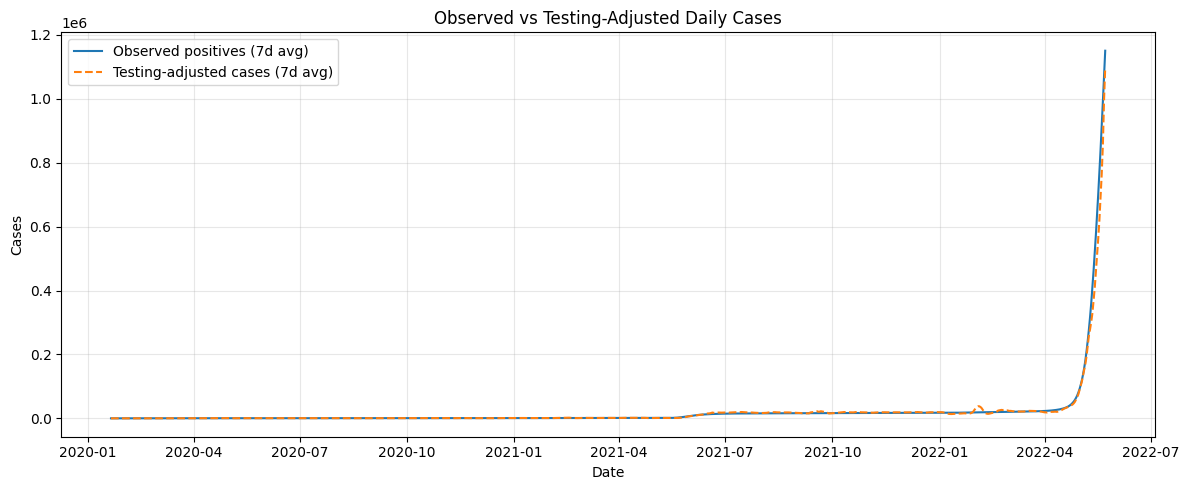

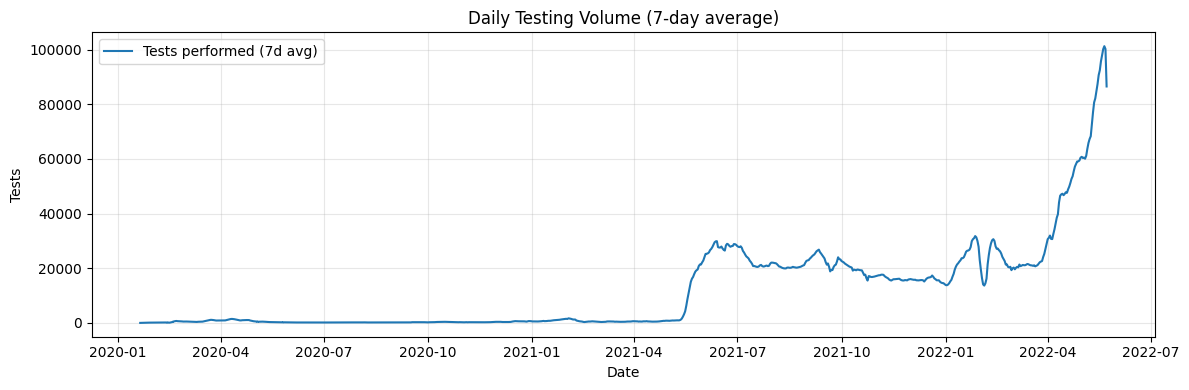

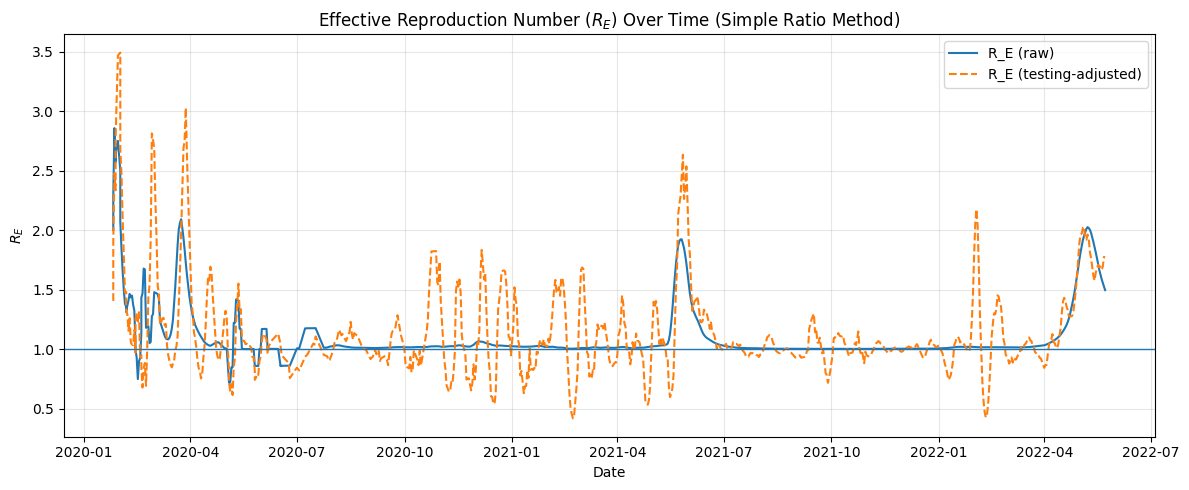

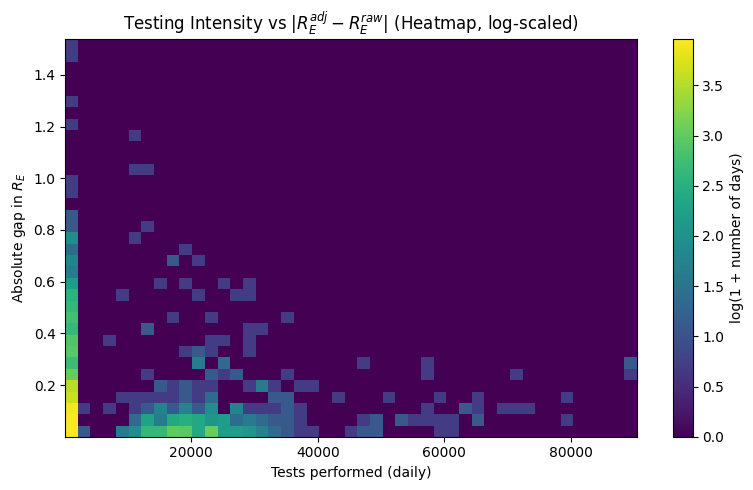

In [ ]:
# Merge in daily testing totals
df_model = df_validate.merge(df_tests_daily, on='date', how='left').sort_values('date').copy()
df_model['tests_total'] = df_model['tests_total'].fillna(0)

# Positivity rate
df_model['positivity'] = np.where(df_model['tests_total'] > 0, df_model['positive_total'] / df_model['tests_total'], np.nan)

# Testing intensity adjustment:
# If tests are lower than the recent typical level, scale cases upward (and vice versa), with a cap to avoid extreme swings.
df_model['tests_ref'] = df_model['tests_total'].rolling(14, min_periods=1).median()
df_model['detect_scale'] = np.where(df_model['tests_total'] > 0, df_model['tests_ref'] / df_model['tests_total'], np.nan)
df_model['detect_scale'] = pd.Series(df_model['detect_scale']).clip(lower=0.5, upper=3.0)
df_model['detect_scale'] = df_model['detect_scale'].fillna(1.0)

df_model['cases_adjusted'] = df_model['positive_total'] * df_model['detect_scale']

# Estimate effective reproduction number R_E using a simple ratio method:
# R_E(t) ≈ I(t) / I(t - s), where s is an assumed serial interval in days.
serial_interval_days = 5

df_model['incidence_smooth'] = df_model['positive_total'].rolling(7, min_periods=1).mean()
df_model['incidence_adj_smooth'] = df_model['cases_adjusted'].rolling(7, min_periods=1).mean()

df_model['R_E_raw'] = df_model['incidence_smooth'] / df_model['incidence_smooth'].shift(serial_interval_days)
df_model['R_E_adj'] = df_model['incidence_adj_smooth'] / df_model['incidence_adj_smooth'].shift(serial_interval_days)

# How does testing intensity relate to "estimation stability"?
df_model['R_E_gap'] = (df_model['R_E_adj'] - df_model['R_E_raw']).abs()

corr_tests_gap = df_model[['tests_total','R_E_gap']].dropna().corr().iloc[0,1]
corr_tests_pos = df_model[['tests_total','positivity']].dropna().corr().iloc[0,1]

print("Correlation (tests_total vs |R_E_adj - R_E_raw|):", round(corr_tests_gap, 4))
print("Correlation (tests_total vs positivity):", round(corr_tests_pos, 4))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_model['date'], df_model['positive_total'].rolling(7, min_periods=1).mean(), label='Observed positives (7d avg)')
plt.plot(df_model['date'], df_model['cases_adjusted'].rolling(7, min_periods=1).mean(), label='Testing-adjusted cases (7d avg)', linestyle='--')
plt.title('Observed vs Testing-Adjusted Daily Cases')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df_model['date'], df_model['tests_total'].rolling(7, min_periods=1).mean(), label='Tests performed (7d avg)')
plt.title('Daily Testing Volume (7-day average)')
plt.xlabel('Date')
plt.ylabel('Tests')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_model['date'], df_model['R_E_raw'], label='R_E (raw)')
plt.plot(df_model['date'], df_model['R_E_adj'], label='R_E (testing-adjusted)', linestyle='--')
plt.axhline(1.0, linewidth=1)
plt.title('Effective Reproduction Number ($R_E$) Over Time (Simple Ratio Method)')
plt.xlabel('Date')
plt.ylabel('$R_E$')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Testing intensity vs R_E gap
heat_df = df_model[['tests_total', 'R_E_gap']].dropna()

x = heat_df['tests_total'].astype(float).values
y = heat_df['R_E_gap'].astype(float).values

x_lo, x_hi = np.percentile(x, [1, 99])
mask = (x >= x_lo) & (x <= x_hi)
x = x[mask]
y = y[mask]

bins_x, bins_y = 45, 35
H, xedges, yedges = np.histogram2d(x, y, bins=[bins_x, bins_y])
H_log = np.log1p(H)  # log(1 + count)

nonzero = H_log[H_log > 0]
vmax = np.percentile(nonzero, 99) if nonzero.size > 0 else None

plt.figure(figsize=(8, 5))
img = plt.imshow(
    H_log.T,
    origin='lower',
    aspect='auto',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='viridis',
    vmin=0,
    vmax=vmax
)

plt.colorbar(img, label='log(1 + number of days)')
plt.title('Testing Intensity vs $|R_E^{adj} - R_E^{raw}|$ (Heatmap, log-scaled)')
plt.xlabel('Tests performed (daily)')
plt.ylabel('Absolute gap in $R_E$')
plt.tight_layout()
plt.show()
